📊 Loading collected data...
✅ Loaded: 1309 edges, 1296 nodes, 1452 interactions

🧹 After cleaning: 1305 edges, 1426 interactions
1️⃣  SUPER-SPREADERS (Users who spread memes across communities)

🌟 Top 10 Super-Spreaders (engage in multiple subreddits):

   BrainArson           → Active in 2 different subreddits
   Early-Strategy5206   → Active in 2 different subreddits
   HubrisOfApollo       → Active in 2 different subreddits
   MCSquaredBoi         → Active in 2 different subreddits
   MahmoudAO            → Active in 2 different subreddits
   Mainely420Gaming     → Active in 2 different subreddits
   MeBollasDellero      → Active in 2 different subreddits
   MeganLuxy            → Active in 2 different subreddits
   RustleThemJimmiez    → Active in 2 different subreddits
   Slow_Fish2601        → Active in 2 different subreddits

📂 Saved super-spreaders to 'super_spreaders.csv'

2️⃣  MEME VELOCITY (Engagement patterns over time)

⏰ Peak Meme Activity Hours:
   18:00 - 89 interaction

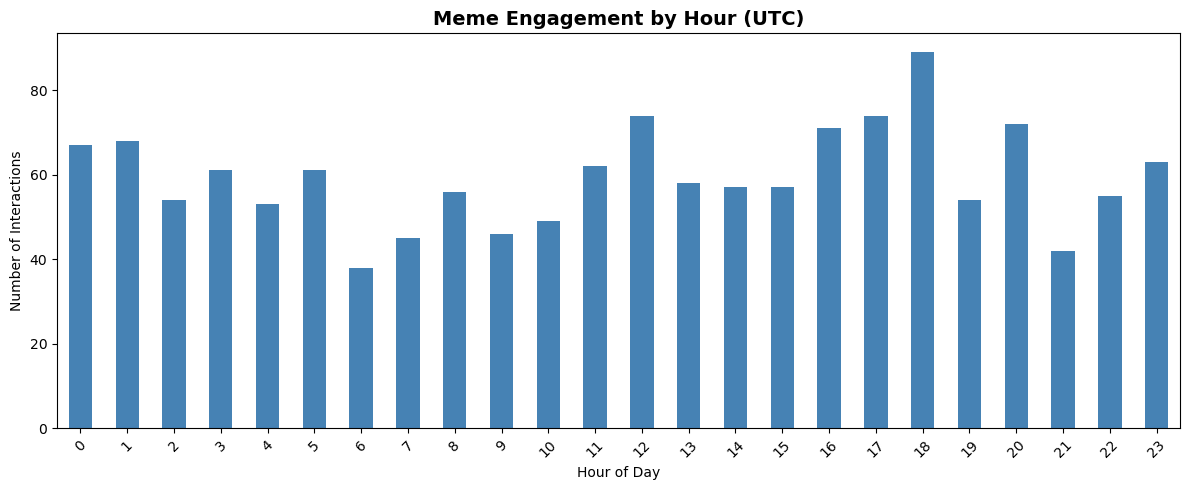

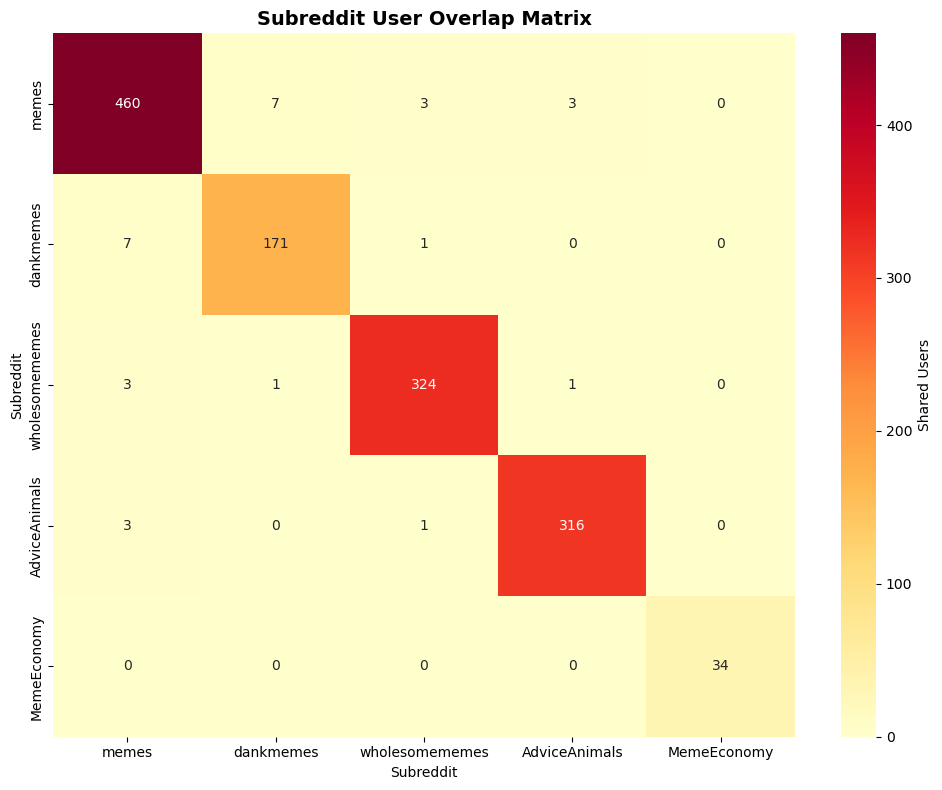

In [3]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np

"""
ADVANCED MEME SPREAD ANALYSIS (FIXED)
------------------------------
Analyzes the collected Reddit data to understand meme propagation patterns
Run this BEFORE importing into Gephi for deeper insights
"""

print("📊 Loading collected data...")

# Load the data
df_edges = pd.read_csv('reddit_meme_network_edges.csv')
df_nodes = pd.read_csv('reddit_meme_network_nodes.csv')
df_detailed = pd.read_csv('reddit_interactions_detailed.csv')

print(f"✅ Loaded: {len(df_edges)} edges, {len(df_nodes)} nodes, {len(df_detailed)} interactions\n")

# Clean data - remove NaN users and convert to string
df_edges = df_edges.dropna(subset=['user'])
df_detailed = df_detailed.dropna(subset=['user'])
df_edges['user'] = df_edges['user'].astype(str)
df_detailed['user'] = df_detailed['user'].astype(str)

# Remove deleted users
df_edges = df_edges[df_edges['user'] != 'None']
df_detailed = df_detailed[df_detailed['user'] != 'None']

print(f"🧹 After cleaning: {len(df_edges)} edges, {len(df_detailed)} interactions")

# -------------------------
# 1. IDENTIFY SUPER-SPREADERS
# -------------------------
print("=" * 60)
print("1️⃣  SUPER-SPREADERS (Users who spread memes across communities)")
print("=" * 60)

# Users who post/comment in multiple subreddits
user_subreddit_count = df_detailed.groupby('user')['target_subreddit'].nunique().reset_index()
user_subreddit_count.columns = ['user', 'subreddit_count']
cross_community_users = user_subreddit_count[user_subreddit_count['subreddit_count'] > 1].sort_values('subreddit_count', ascending=False)

print(f"\n🌟 Top 10 Super-Spreaders (engage in multiple subreddits):\n")
for idx, row in cross_community_users.head(10).iterrows():
    username = str(row['user'])[:20]  # Truncate long usernames
    print(f"   {username:<20s} → Active in {int(row['subreddit_count'])} different subreddits")

# Save super-spreaders
cross_community_users.to_csv('super_spreaders.csv', index=False)
print(f"\n📂 Saved super-spreaders to 'super_spreaders.csv'")

# -------------------------
# 2. MEME VELOCITY (How fast memes spread)
# -------------------------
print("\n" + "=" * 60)
print("2️⃣  MEME VELOCITY (Engagement patterns over time)")
print("=" * 60)

df_detailed['timestamp'] = pd.to_datetime(df_detailed['timestamp'])
df_detailed['hour'] = df_detailed['timestamp'].dt.hour

# Engagement by hour
hourly_engagement = df_detailed.groupby('hour').size()

print("\n⏰ Peak Meme Activity Hours:")
top_hours = hourly_engagement.sort_values(ascending=False).head(5)
for hour, count in top_hours.items():
    print(f"   {hour:02d}:00 - {count} interactions")

# Plot
plt.figure(figsize=(12, 5))
hourly_engagement.plot(kind='bar', color='steelblue')
plt.title('Meme Engagement by Hour (UTC)', fontsize=14, fontweight='bold')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Interactions')
plt.xticks(rotation=45)
plt.tight_layout()

# -------------------------
# 3. CROSS-POSTING PATTERNS
# -------------------------
print("\n" + "=" * 60)
print("3️⃣  CROSS-POSTING PATTERNS (Memes appearing in multiple subreddits)")
print("=" * 60)

# Find posts that appear in analysis from same users across subreddits
user_subreddit_matrix = df_detailed.groupby(['user', 'target_subreddit']).size().reset_index(name='count')
users_in_multiple = user_subreddit_matrix.groupby('user')['target_subreddit'].count()
multi_sub_users = users_in_multiple[users_in_multiple > 1]

print(f"\n🔄 {len(multi_sub_users)} users engage across multiple subreddits")
print(f"   This shows memes spreading through these bridge users!")

# Create subreddit-to-subreddit connections (via shared users)
subreddit_connections = []

for user in multi_sub_users.index:
    user_subs = df_detailed[df_detailed['user'] == user]['target_subreddit'].unique()
    
    # Create connections between all pairs of subreddits this user engages with
    for i, sub1 in enumerate(user_subs):
        for sub2 in user_subs[i+1:]:
            subreddit_connections.append({
                'source_subreddit': sub1,
                'target_subreddit': sub2,
                'bridge_user': user
            })

df_sub_connections = pd.DataFrame(subreddit_connections)

if len(df_sub_connections) > 0:
    # Count connections between subreddits
    sub_network = df_sub_connections.groupby(['source_subreddit', 'target_subreddit']).size().reset_index(name='shared_users')
    sub_network = sub_network.sort_values('shared_users', ascending=False)
    
    print("\n🌉 Strongest Subreddit Bridges (most shared users):\n")
    for idx, row in sub_network.head(10).iterrows():
        print(f"   r/{row['source_subreddit']:<15s} ↔ r/{row['target_subreddit']:<15s} : {int(row['shared_users'])} shared users")
    
    # Save subreddit network
    sub_network.to_csv('subreddit_network.csv', index=False)
    print(f"\n📂 Saved subreddit connections to 'subreddit_network.csv'")
    print("   → Import this into Gephi to see how subreddits are connected!")

# -------------------------
# 4. ENGAGEMENT METRICS
# -------------------------
print("\n" + "=" * 60)
print("4️⃣  ENGAGEMENT QUALITY (Comment scores)")
print("=" * 60)

avg_scores = df_detailed.groupby('target_subreddit')['comment_score'].agg(['mean', 'median', 'max'])
avg_scores = avg_scores.sort_values('mean', ascending=False)

print("\n⭐ Subreddit Engagement Quality (average comment scores):\n")
for subreddit, row in avg_scores.iterrows():
    print(f"   r/{subreddit:<20s} - Avg: {row['mean']:.1f}, Max: {int(row['max'])}")

# -------------------------
# 5. NETWORK METRICS (Basic)
# -------------------------
print("\n" + "=" * 60)
print("5️⃣  BASIC NETWORK METRICS")
print("=" * 60)

# Build network - using cleaned data
G = nx.Graph()

for _, row in df_edges.iterrows():
    if pd.notna(row['user']) and str(row['user']) != 'None':
        G.add_edge(str(row['user']), row['target_subreddit'], weight=row['weight'])

print(f"\n📈 Network Statistics:")
print(f"   Nodes: {G.number_of_nodes()}")
print(f"   Edges: {G.number_of_edges()}")

if G.number_of_nodes() > 0:
    print(f"   Average Degree: {sum(dict(G.degree()).values()) / G.number_of_nodes():.2f}")
    print(f"   Network Density: {nx.density(G):.4f}")

    # Connected components
    components = list(nx.connected_components(G))
    print(f"   Connected Components: {len(components)}")
    if components:
        print(f"   Largest Component Size: {len(max(components, key=len))} nodes")

    # Most central nodes (by degree)
    degree_dict = dict(G.degree())
    top_nodes = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)[:10]

    print(f"\n🎯 Most Connected Nodes (Degree Centrality):\n")
    for node, degree in top_nodes:
        node_type = 'subreddit' if node.startswith('r/') or node in df_detailed['target_subreddit'].unique() else 'user'
        node_display = str(node)[:30]  # Truncate long names
        print(f"   {node_display:<30s} - {degree} connections ({node_type})")

# -------------------------
# 6. COMMUNITY OVERLAP MATRIX
# -------------------------
print("\n" + "=" * 60)
print("6️⃣  COMMUNITY OVERLAP ANALYSIS")
print("=" * 60)

# Create matrix showing user overlap between subreddits
subreddits = df_detailed['target_subreddit'].unique()
overlap_matrix = pd.DataFrame(0, index=subreddits, columns=subreddits)

for sub1 in subreddits:
    users_sub1 = set(df_detailed[df_detailed['target_subreddit'] == sub1]['user'])
    for sub2 in subreddits:
        users_sub2 = set(df_detailed[df_detailed['target_subreddit'] == sub2]['user'])
        overlap = len(users_sub1.intersection(users_sub2))
        overlap_matrix.loc[sub1, sub2] = overlap

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(overlap_matrix, annot=True, fmt='d', cmap='YlOrRd', cbar_kws={'label': 'Shared Users'})
plt.title('Subreddit User Overlap Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Subreddit')
plt.ylabel('Subreddit')
plt.tight_layout()
print("   This shows which subreddit communities share the most users!")

overlap_matrix.to_csv('subreddit_overlap_matrix.csv')
print("📂 Saved matrix data to 'subreddit_overlap_matrix.csv'")

In [5]:
# -------------------------
# 7. SUMMARY REPORT
# -------------------------
print("\n" + "=" * 60)
print("📋 SUMMARY REPORT FOR YOUR PROJECT")
print("=" * 60)

most_active_sub = df_detailed.groupby('target_subreddit').size().idxmax() if len(df_detailed) > 0 else "N/A"
peak_hour = hourly_engagement.idxmax() if len(hourly_engagement) > 0 else "N/A"

print(f"""
KEY FINDINGS:
-------------
1. Network Size: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges
2. Super-Spreaders: {len(multi_sub_users)} users engage across multiple communities
3. Cross-Community Bridges: {len(df_sub_connections) if len(df_sub_connections) > 0 else 0} connections between subreddits
4. Most Active Subreddit: r/{most_active_sub}
5. Peak Activity: {peak_hour}:00 UTC
6. Network Density: {nx.density(G):.4f} (how interconnected the network is)
""")

print("\n🎉 Analysis complete!")


📋 SUMMARY REPORT FOR YOUR PROJECT

KEY FINDINGS:
-------------
1. Network Size: 1295 nodes, 1305 edges
2. Super-Spreaders: 15 users engage across multiple communities
3. Cross-Community Bridges: 15 connections between subreddits
4. Most Active Subreddit: r/memes
5. Peak Activity: 18:00 UTC
6. Network Density: 0.0016 (how interconnected the network is)


🎉 Analysis complete!


GENERATING ALL VISUALIZATIONS FOR REDDIT MEME SPREAD ANALYSIS

📊 Loading data...
✅ Loaded and cleaned data

1️⃣  SUBREDDIT-TO-SUBREDDIT NETWORK


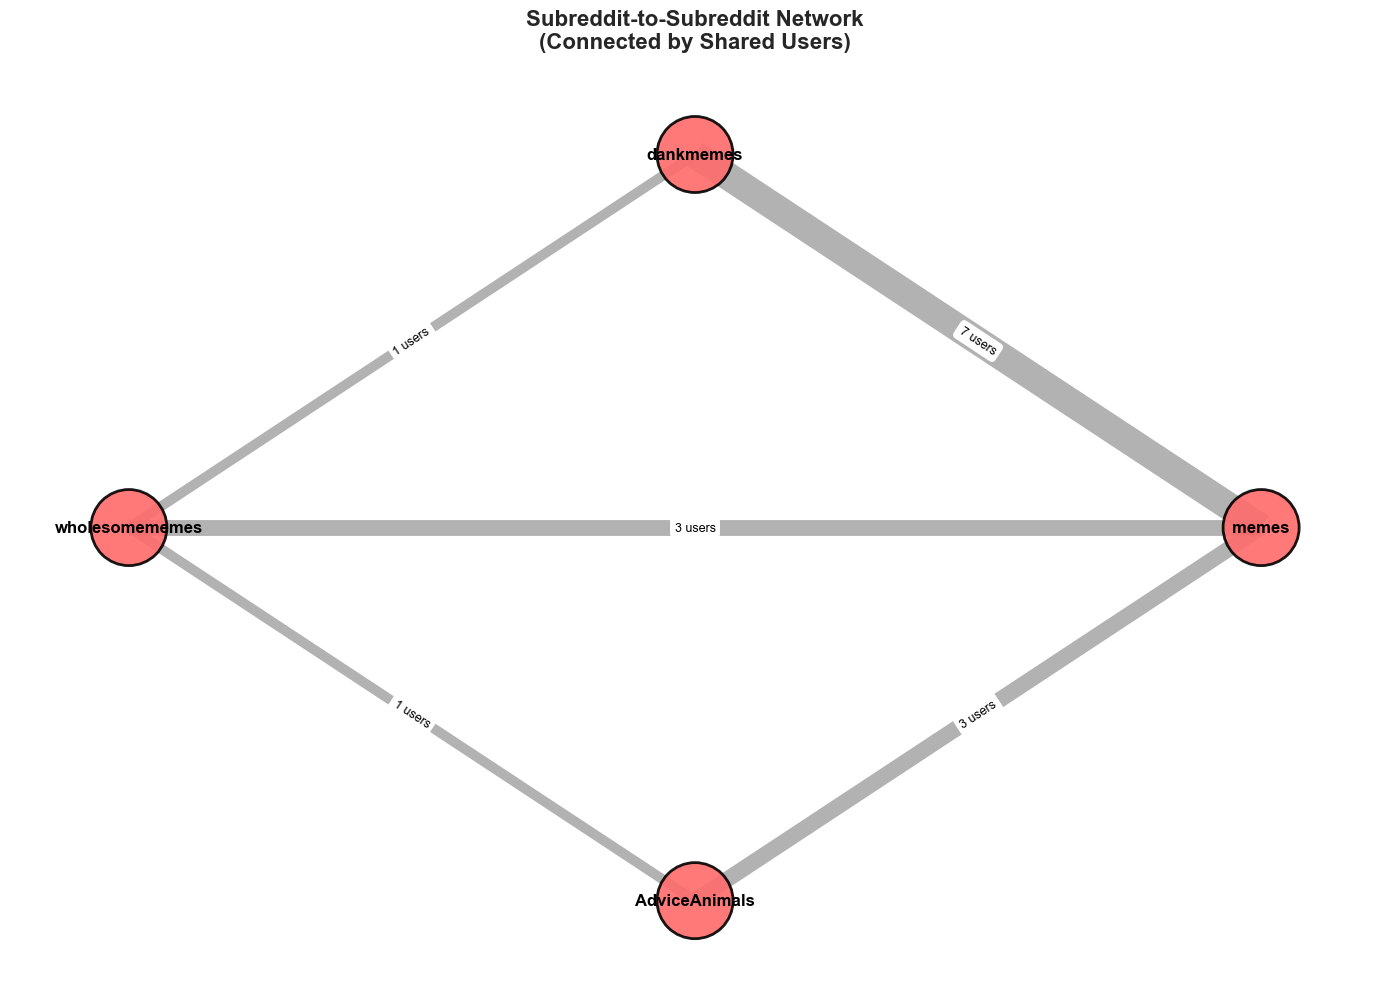


3️⃣  ENGAGEMENT QUALITY BY SUBREDDIT


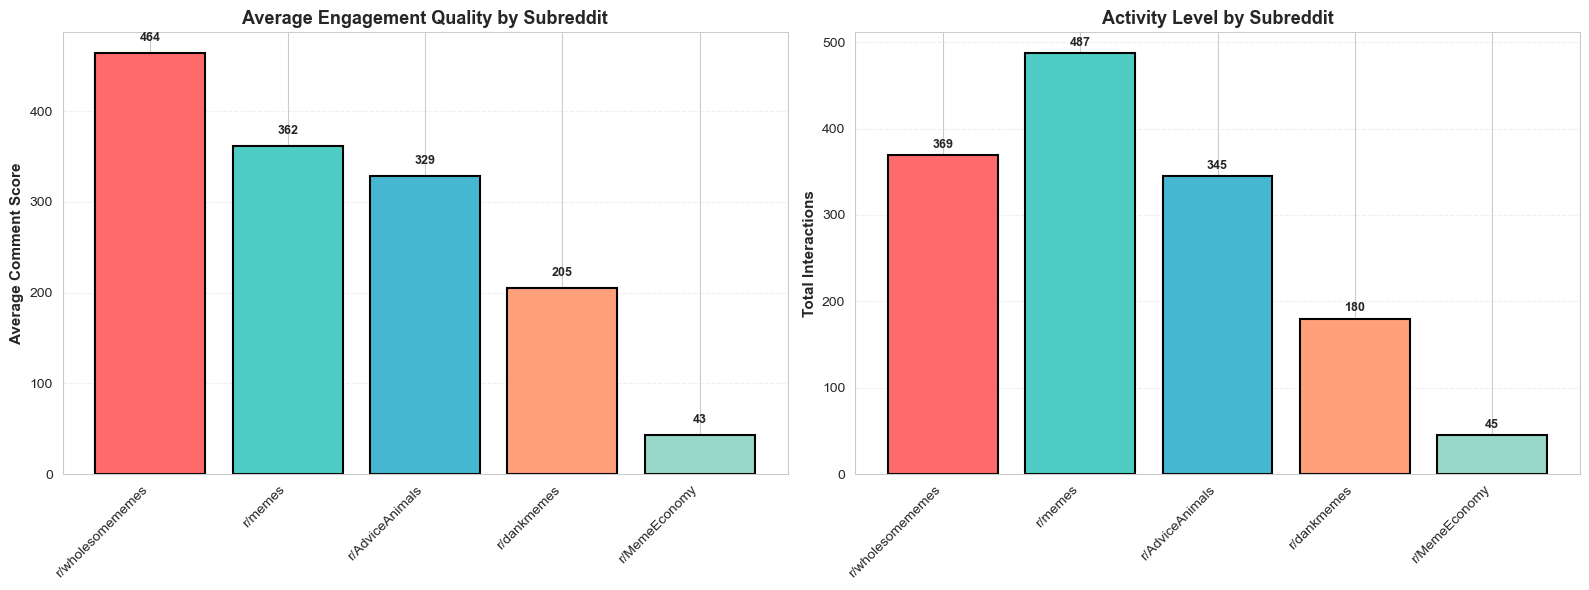


✅ ALL VISUALIZATIONS GENERATED SUCCESSFULLY!


In [8]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np

print("=" * 70)
print("GENERATING ALL VISUALIZATIONS FOR REDDIT MEME SPREAD ANALYSIS")
print("=" * 70)

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.facecolor'] = 'white'

# Load data
print("\n📊 Loading data...")
df_edges = pd.read_csv('reddit_meme_network_edges.csv')
df_nodes = pd.read_csv('reddit_meme_network_nodes.csv')
df_detailed = pd.read_csv('reddit_interactions_detailed.csv')

# Clean data
df_edges = df_edges.dropna(subset=['user'])
df_detailed = df_detailed.dropna(subset=['user'])
df_edges['user'] = df_edges['user'].astype(str)
df_detailed['user'] = df_detailed['user'].astype(str)
df_edges = df_edges[df_edges['user'] != 'None']
df_detailed = df_detailed[df_detailed['user'] != 'None']

print(f"✅ Loaded and cleaned data")

# =============================================================================
# VISUALIZATION 1: SUBREDDIT-TO-SUBREDDIT NETWORK
# =============================================================================
print("\n" + "=" * 70)
print("1️⃣  SUBREDDIT-TO-SUBREDDIT NETWORK")
print("=" * 70)

# Load subreddit network
df_sub_network = pd.read_csv('subreddit_network.csv')

# Create network
G_subs = nx.Graph()
for _, row in df_sub_network.iterrows():
    G_subs.add_edge(row['source_subreddit'], row['target_subreddit'], 
                    weight=row['shared_users'])

# Create visualization
fig, ax = plt.subplots(figsize=(14, 10))

# Position nodes in a circle
pos = nx.circular_layout(G_subs)

# Draw edges with width based on weight
edges = G_subs.edges()
weights = [G_subs[u][v]['weight'] for u, v in edges]
max_weight = max(weights)

# Normalize weights for visualization
edge_widths = [5 + (w / max_weight) * 15 for w in weights]

nx.draw_networkx_edges(G_subs, pos, width=edge_widths, alpha=0.6, edge_color='gray')

# Draw nodes
node_sizes = [3000] * len(G_subs.nodes())
nx.draw_networkx_nodes(G_subs, pos, node_size=node_sizes, 
                       node_color='#FF6B6B', alpha=0.9, 
                       edgecolors='black', linewidths=2)

# Draw labels
nx.draw_networkx_labels(G_subs, pos, font_size=12, font_weight='bold')

# Add edge labels (shared users count)
edge_labels = nx.get_edge_attributes(G_subs, 'weight')
edge_labels = {k: f"{v} users" for k, v in edge_labels.items()}
nx.draw_networkx_edge_labels(G_subs, pos, edge_labels, font_size=9)

plt.title('Subreddit-to-Subreddit Network\n(Connected by Shared Users)', 
          fontsize=16, fontweight='bold', pad=20)
plt.axis('off')
plt.tight_layout()
plt.show()
plt.close()

# # Load super-spreaders
df_super = pd.read_csv('super_spreaders.csv')
top_10 = df_super.head(10)

# =============================================================================
# VISUALIZATION 3: ENGAGEMENT QUALITY BY SUBREDDIT
# =============================================================================
print("\n" + "=" * 70)
print("3️⃣  ENGAGEMENT QUALITY BY SUBREDDIT")
print("=" * 70)

# Calculate engagement metrics
engagement_stats = df_detailed.groupby('target_subreddit')['comment_score'].agg([
    ('avg_score', 'mean'),
    ('median_score', 'median'),
    ('max_score', 'max'),
    ('total_interactions', 'count')
]).reset_index()

engagement_stats = engagement_stats.sort_values('avg_score', ascending=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Chart 1: Average Engagement Score
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8']
bars1 = ax1.bar(range(len(engagement_stats)), engagement_stats['avg_score'], 
                color=colors, edgecolor='black', linewidth=1.5)

ax1.set_xticks(range(len(engagement_stats)))
ax1.set_xticklabels([f"r/{sub}" for sub in engagement_stats['target_subreddit']], 
                     rotation=45, ha='right', fontsize=10)
ax1.set_ylabel('Average Comment Score', fontsize=11, fontweight='bold')
ax1.set_title('Average Engagement Quality by Subreddit', fontsize=13, fontweight='bold')
ax1.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels
for i, (idx, row) in enumerate(engagement_stats.iterrows()):
    ax1.text(i, row['avg_score'] + 10, f"{row['avg_score']:.0f}", 
             ha='center', va='bottom', fontsize=9, fontweight='bold')

# Chart 2: Total Interactions
bars2 = ax2.bar(range(len(engagement_stats)), engagement_stats['total_interactions'], 
                color=colors, edgecolor='black', linewidth=1.5)

ax2.set_xticks(range(len(engagement_stats)))
ax2.set_xticklabels([f"r/{sub}" for sub in engagement_stats['target_subreddit']], 
                     rotation=45, ha='right', fontsize=10)
ax2.set_ylabel('Total Interactions', fontsize=11, fontweight='bold')
ax2.set_title('Activity Level by Subreddit', fontsize=13, fontweight='bold')
ax2.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels
for i, (idx, row) in enumerate(engagement_stats.iterrows()):
    ax2.text(i, row['total_interactions'] + 5, f"{int(row['total_interactions'])}", 
             ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()
plt.close()

# # Build full network
G = nx.Graph()
for _, row in df_edges.iterrows():
    G.add_edge(row['user'], row['target_subreddit'], weight=row['weight'])

# # Identify node types
subreddit_nodes = df_detailed['target_subreddit'].unique()
user_nodes = [n for n in G.nodes() if n not in subreddit_nodes]

# =============================================================================
# SUMMARY
# =============================================================================
print("\n" + "=" * 70)
print("✅ ALL VISUALIZATIONS GENERATED SUCCESSFULLY!")

Creating centrality visualization...


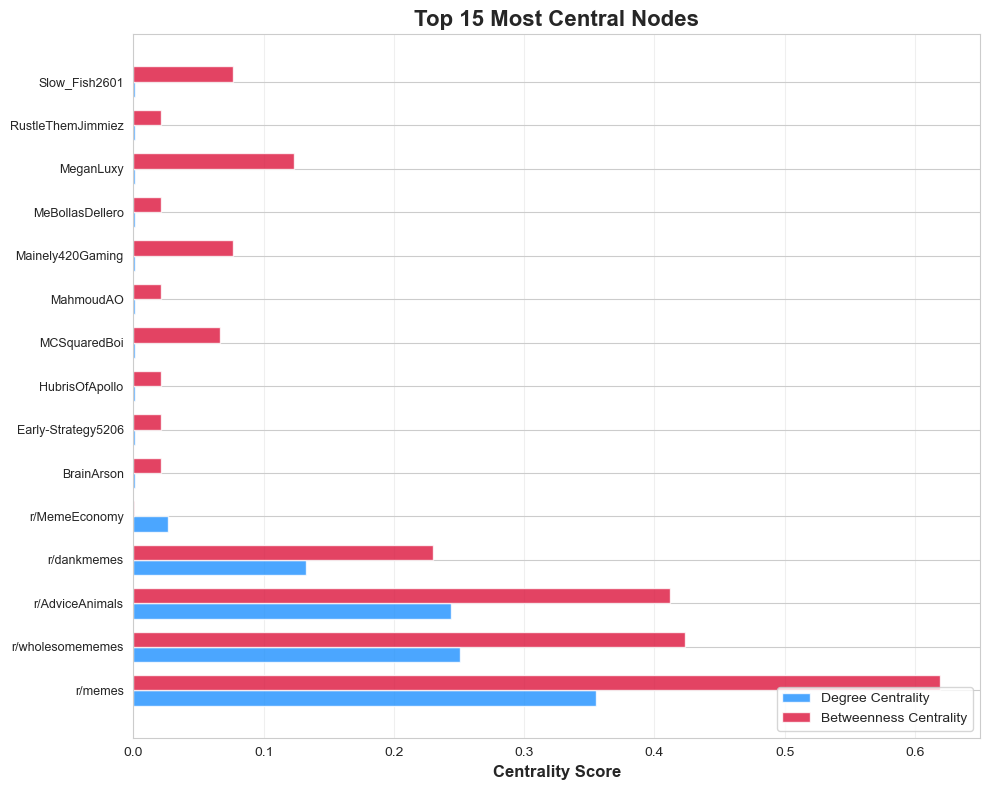


📊 Network Statistics:
   Nodes: 1295
   Edges: 1305
   Avg Degree: 2.02
   Network Density: 0.0016
   Connected Components: 2


In [9]:
print("Creating centrality visualization...")

plt.figure(figsize=(10, 8))
plt.title('Top 15 Most Central Nodes', fontsize=16, fontweight='bold')

degree_cent = nx.degree_centrality(G)
betweenness_cent = nx.betweenness_centrality(G)

# Get top nodes
top_nodes = []
for node, cent in sorted(degree_cent.items(), key=lambda x: x[1], reverse=True):
    if node is not None and isinstance(node, str) and node != 'None':
        top_nodes.append((node, cent))
    if len(top_nodes) >= 15:
        break

# Prepare labels
node_names = []
for node, _ in top_nodes:
    if node in subreddits:
        node_names.append(f"r/{node}"[:20])
    else:
        node_names.append(str(node)[:20])

degree_vals = [degree_cent[n[0]] for n in top_nodes]
between_vals = [betweenness_cent[n[0]] for n in top_nodes]

x = np.arange(len(node_names))
width = 0.35

bars1 = plt.barh(x - width/2, degree_vals, width, label='Degree Centrality', 
                 color='dodgerblue', alpha=0.8)
bars2 = plt.barh(x + width/2, between_vals, width, label='Betweenness Centrality', 
                 color='crimson', alpha=0.8)

plt.yticks(x, node_names, fontsize=9)
plt.xlabel('Centrality Score', fontsize=12, fontweight='bold')
plt.legend(loc='lower right', frameon=True, fancybox=True)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# ========================================
# NETWORK STATS
# ========================================
degrees = [d for n, d in G.degree()]
print("\n📊 Network Statistics:")
print(f"   Nodes: {G.number_of_nodes()}")
print(f"   Edges: {G.number_of_edges()}")
print(f"   Avg Degree: {np.mean(degrees):.2f}")
print(f"   Network Density: {nx.density(G):.4f}")
print(f"   Connected Components: {nx.number_connected_components(G)}")